___

## Particle Prediction - Using Dense Neural Networks
#### DJ Dawkins, Nathan Deinlein, Joseph Lazarus, and Puri Rudick​

DS7333 QTW: Case Study 6
___

This Notebook will cover the following topics in order: 
1. Business Overview and Objectives
2. Data Evaluation and Engineering
3. Modeling Preparations
4. Model Building and Model Evaluation
5. Results, Conclusions and Discussions
6. Moving Forward and Future Research

In [2]:
# Imports necessary python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

---
### Business Overview and Objectives
The goal for this case study is to build a classification model using a dense neural network to distinguish between the existance of a new particle or not.

The goal is to maximize the accuracy and describe the decisions made while designing and building the network as well as determining when the model has sufficiently finished training. 

---
### Data Evaluation and Engineering

#### **Data Description:**
- There is a total of 7 million observations in the dataset.
- The dataset contains 28 features (named f0 to f26, and mass).  All features are numerical variables.
    - 22 of the features are continous variables.
    - 6 of the features; f5, f9, f13, f17, f21, and mass, are numerical categorical variables.
    - These can be observed using the histogram plots below.
- The target variable is binary, called '# label' with 2 values: '0' for Non-Detection and '1' for Detection. The classes are balanced with the positve target value having a prevlaence of ~50%.
    - *3,499,121* observations for '0' or Non-Detection class
    - *3,500,879* observations for '1' or Detection class


In [3]:
# Read in data

# The file is 1.63GB, which is too big for Github
# Save the file locally and read in using the file's path

path = 'C:/Users/puri.rudick/Downloads/all_train.csv.gz'
# path = '/Users/puri/DataScience@SMU/10.DS7333 QTW/all_train.csv.gz'
# path = "C:/Users/OaklandHillsMansion/OneDrive - Southern Methodist University/SMU/DS 7333 Quantify World/QTW_Week11_Files/all_train.csv.gz"

df = pd.read_csv(path, compression='gzip', on_bad_lines='skip')

In [4]:
df.shape

(7000000, 29)

In [5]:
print(df.groupby(['# label'])['# label'].count())

# label
0.0    3499121
1.0    3500879
Name: # label, dtype: int64


#### **Exploratory Data Analysis (EDA):**

**Missing Values and Duplicated Rows**<br>
There is no missing value, and no duplicated rows.

**Statistical Summary Table** of the dataset as shown below.


In [6]:
# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing


In [7]:
# Check for duplicate rows
print('Duplicate rows: ', df.duplicated(keep='first').sum())

Duplicate rows:  0


In [8]:
df.describe()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
count,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,...,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06
mean,5.001256e-01,1.612528e-02,4.770022e-04,2.686578e-05,1.056081e-02,-1.050026e-04,2.765919e-03,1.815953e-02,2.510948e-05,4.345870e-04,...,1.164789e-02,-1.127097e-04,7.686731e-05,2.909202e-04,1.228774e-02,9.778378e-03,5.269844e-03,-1.760961e-03,1.533136e-02,1.000107e+03
std,5.000000e-01,1.004417e+00,9.974864e-01,1.000080e+00,9.956003e-01,9.998670e-01,1.000957e+00,9.867746e-01,9.965867e-01,1.000007e+00,...,1.002725e+00,1.000038e+00,1.000033e+00,1.000170e+00,1.010477e+00,1.005418e+00,1.009990e+00,9.844511e-01,9.822799e-01,3.534255e+02
min,0.000000e+00,-1.960549e+00,-2.365355e+00,-1.732165e+00,-9.980274e+00,-1.732137e+00,-1.054221e+00,-3.034787e+00,-2.757853e+00,-1.732359e+00,...,-1.728284e+00,-2.281867e+00,-1.731758e+00,-5.736825e-01,-3.631608e+00,-4.729473e+00,-2.062223e+01,-3.452634e+00,-2.632761e+00,5.000000e+02
25%,0.000000e+00,-7.288206e-01,-7.332548e-01,-8.656704e-01,-6.092291e-01,-8.658025e-01,-1.054221e+00,-7.566092e-01,-7.014146e-01,-8.656543e-01,...,-7.423630e-01,-7.206846e-01,-8.656855e-01,-5.736825e-01,-5.417942e-01,-5.115522e-01,-3.543870e-01,-6.925097e-01,-7.943804e-01,7.500000e+02
50%,1.000000e+00,-3.930319e-02,8.523957e-04,3.199154e-04,1.963316e-02,-5.070131e-04,-5.983562e-03,-1.499527e-01,-1.067553e-04,1.384781e-03,...,-8.992496e-02,-6.735953e-05,-4.424527e-04,-5.736825e-01,-1.602760e-01,-3.144032e-01,-3.265228e-01,-3.570301e-01,-8.828640e-02,1.000000e+03
75%,1.000000e+00,6.900799e-01,7.347832e-01,8.659464e-01,6.798818e-01,8.657646e-01,8.504885e-01,7.686690e-01,7.013194e-01,8.665976e-01,...,6.423185e-01,7.204921e-01,8.659566e-01,-5.736825e-01,4.812194e-01,1.634892e-01,-2.337671e-01,4.753128e-01,7.610846e-01,1.250000e+03
max,1.000000e+00,4.378282e+00,2.365287e+00,1.732370e+00,4.148023e+00,1.731978e+00,4.482618e+00,3.720345e+00,2.758590e+00,1.731450e+00,...,5.866367e+00,2.282217e+00,1.732740e+00,1.743123e+00,7.293420e+00,9.333287e+00,1.499064e+01,5.277313e+00,4.444690e+00,1.500000e+03


**Data Distribution and Correlation:**<br>

Too look at data distribution and correlation, we plotted histogrames, box plots, and correlation heatmap below.

**Histograms:**
- All 22 continous variables (everything except f5, f9, f13, f17, f21, and mass) take on either a normal-ish distribution or a uniform distribution.
- For features f0, f3, f6, f10, f14, f18, and f26 the positive and negative classes appear to take on noticiably different shapes.<br>
- Feature f24 values for both positive and negative are predominantly 0.<br>

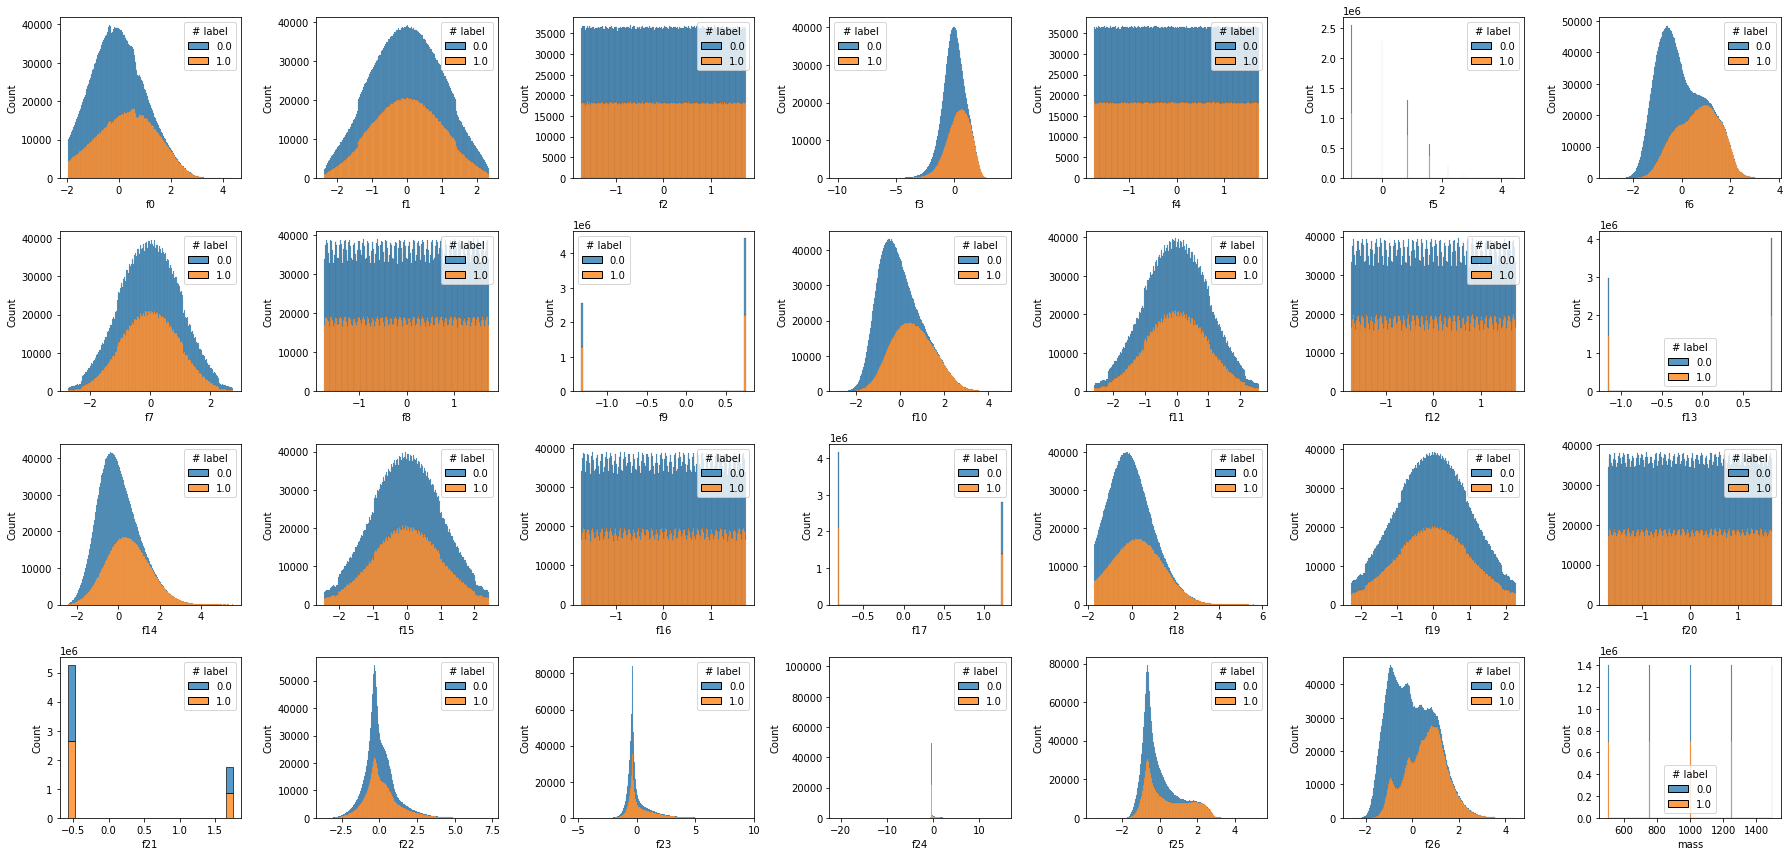

In [9]:
df_features = df.copy()
df_features.drop(["# label"], axis=1, inplace=True)

fig,axs = plt.subplots(4,7, figsize = (25,12))
h, v = 0, 0
for i in df_features.columns:
    sns.histplot(data=df, x=i, hue='# label', multiple='stack', ax=axs[h, v])
    if v == 6:
        h += 1
        v = -1
    v += 1
fig.tight_layout()


**Box Plots:**
- From the observations above, we then plotted f0, f3, f6, f10, f14, f18, f26, and f24. 
- We do not see any major differences within each variable observations between classes in the data for all variables.
- f24 shows strongly predominant at 0.

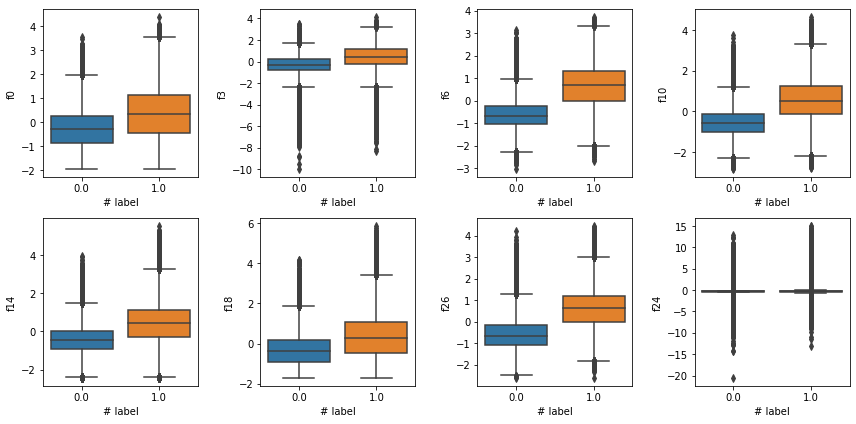

In [10]:
fig,axs = plt.subplots(2, 4, figsize = (12, 6))

sns.boxplot(data=df, x='# label', y='f0', ax=axs[0, 0])
sns.boxplot(data=df, x='# label', y='f3', ax=axs[0, 1])
sns.boxplot(data=df, x='# label', y='f6', ax=axs[0, 2])
sns.boxplot(data=df, x='# label', y='f10', ax=axs[0, 3])
sns.boxplot(data=df, x='# label', y='f14', ax=axs[1, 0])
sns.boxplot(data=df, x='# label', y='f18', ax=axs[1, 1])
sns.boxplot(data=df, x='# label', y='f26', ax=axs[1, 2])
sns.boxplot(data=df, x='# label', y='f24', ax=axs[1, 3])

fig.tight_layout()

**Correlation Heatmap:**
- The correlation heatmap below clearly displays that there is no evidence of correlation was found among any of the features.<br>

<AxesSubplot:>

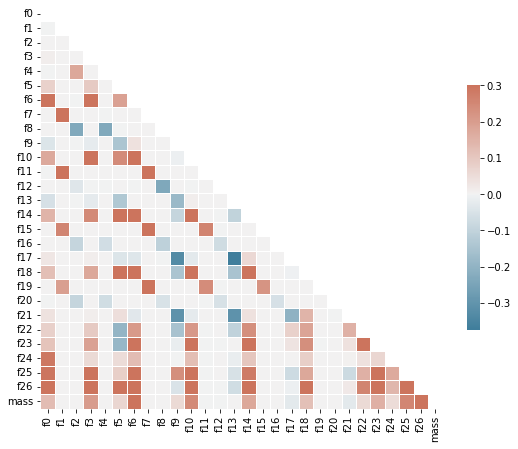

In [11]:
# Get correlation
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

---
<img src="https://miro.medium.com/max/1400/1*bhFifratH9DjKqMBTeQG5A.gif" style="float: right" width="500"/>

### Classification Model Introduction - **Dense Neural Networks**
To approach the objectives of this case study, we used **Dense Neural Network Model**. There are multiple advantages of the algorithm that we aould like to mention here:
- The dataset of 7 million rows, consisting of prodominetly continuous values, is sufficient to train for a neural networks model.
- We are aware that it is close to impossible to interpret a Neural Network model and since interpability is not a requirement, we strongly believe that using Neural Network model is suitable for this study.
- Neural Network can be expected to self-train quite efficiently in case of problems where the relationships are dynamic or nonlinear.

#### **Neural Network**
Neural Network or Artificial Neural Network (ANN) is computing system inspired by biological neural network that constitute animal brain. Such systems “learn” to perform tasks by considering examples, generally without being programmed with any task-specific rules. A Neural Network made of many units of neurons  (also referred to as a "node") which are grouped into layers.<br>

There are 3 main components of the layers:
- **Input layer** — Initial data for the neural network.
- **Hidden layer(s)** — Intermediate layer between input and output layer and place where all the computation is done.
- **Output layer** — Produce the result for given inputs.
<img src="https://miro.medium.com/max/1400/1*upfpVueoUuKPkyX3PR3KBg.png" style="float: right" width="500"/><br>

**Dense Neural Network:** A dense layer is a layer that is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer.


In Neural Network Model, learning process occurs in these steps:
1. Each neuron receives one or more inputs from an external source or from other neurons.
2. Each input is multiplied by a weight to indicate the input's relative importance.
3. The sum of the weighted input(s) is fed into the neuron.
4. Bias is added to the sum of the weighted inputs.
5. An activation function within the neuron performs a calculation on the total.
6. The result is the neuron's output, which is passed to other neurons or delivered to the external world as the machine's output.
7. The output passes through a loss function or cost function that evaluates the accuracy of the neural network's prediction, and results are fed back through the network, indicating adjustments that must be made to the weights and biases.
8. The process is repeated in multiple iterations to optimize the accuracy of the output; weights and biases are adjusted with each iteration.

###### *<div style="text-align: right">Image1 Credits: https://towardsdatascience.com/everything-you-need-to-know-about-neural-networks-and-backpropagation-machine-learning-made-easy-e5285bc2be3a</div>* *<div style="text-align: right">Image2 Credits: https://towardsdatascience.com/whats-the-role-of-weights-and-bias-in-a-neural-network-4cf7e9888a0f</div>*

---
### Model Preparations

1. We used train_test_split function from sklearn to split the dataset into **90% of the dataset to the train and 10% to the test dataset**. <br>
To make sure that we have the validate dataset that is not invaded by model building process.<br>
Using train_test_split function, we have got:
    - Train Dataset: 6.3MM obs. - 3,149,538 as Non-Detected and 3,150,462 as Detected
        - In the training process, **10% of the train dataset is used as validation** in each epoch.
    - Test Dataset: 0.7MM obs. - 349,583 as Non-Detected and 350,417 as Detected
2. **StandardScaler** function from sklearn is used to scale all features.
3. We built a function used for model compiling and evaluation, which we will discuss more in the next section.


#### Split train and test dataset

In [12]:
from sklearn.model_selection import train_test_split

model_data = df.copy()

feature_data = model_data.copy()
feature_data.drop(["# label"], axis=1, inplace=True)

target_data = model_data['# label']

# Splitted train and test dataset
X_train, X_test, y_train, y_test = train_test_split(feature_data,target_data,test_size=0.10,random_state=0)

print("Size of modeling set or train set: ", X_train.shape)
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print("Size of hold back as test set: ", X_test.shape)
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Size of modeling set or train set:  (6300000, 28)
1.0    3150462
0.0    3149538
Name: # label, dtype: int64
1.0    0.500073
0.0    0.499927
Name: # label, dtype: float64
Size of hold back as test set:  (700000, 28)
1.0    350417
0.0    349583
Name: # label, dtype: int64
1.0    0.500596
0.0    0.499404
Name: # label, dtype: float64


#### Scale all features using StandardScaler

In [13]:
#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_ = scl_obj.transform(X_train)

scl_obj.fit(X_test)
X_test_ = scl_obj.transform(X_test)

---
### Model Building

According to model introduction above, the higher number of (hidden) layers and higher number of neurons per layer mean the more complexity of the model.<br>
Adding more complexity to improve model performance does put your model at risk of overfitting the training data.<br>

To observe this hypothesis, we started with building 3 models with different number of layers and neorons to see how the level of complexity affects model's performance.<br>
After that, we pick the model that gives the highest accury when applied to the train dataset and tune its parameters to prevent model overfitting and underfitting. **We built 6 models in total**.<br> 
We will discuss more in detail for each model in its section below.

All models have the **same set up for the parameters below**:
- **Loss function to minimize: Binary Crossentropy** which computes the cross-entropy loss between true labels and predicted labels.
- **Optimizer: Adam**: Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
- **List of metrics to monitor: Accuracy and F1** which we will explain more in the upcomming section.
- **EarlyStopping which monitor Validation Binary Crossentropy with patience=5** is added to stop the training process when there is no improvement in the validation Binary Crossentropy for five consecutive epochs.
- **100 Epochs with Batchsize = 10,000**
- All other parameters such as learning rate were left to defaults, and no regularization such as L2 or drop layers were included.

In [14]:
# TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(1234)

print(tf.__version__)

2.9.1


### Model Evaluation

To evaluate the models, we measured the matrices below for each model on the test dataset.

**1) Binary crossentropy** is a loss function that is used in binary classification tasks. It compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value.  Using Binary crossentropy allows us to see how close or far from the actual value.

**2) Accuracy**: Model accuracy is defined as the number of classifications a model correctly predicts divided by the total number of predictions made. In other words, 'what percent of our particle existance prediction is right?'.

**3) F1 Score**: The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. In other words, 'it is an average of presicion and recall'.
- *Precision* measures the model's performance in classifying a sample as positive. In other words, 'what percent of particle existance prediction were corrected?'.
- *Recall* measures the model's ability to detect Positive samples. The higher the recall, the more positive samples detected. In other words, 'what percent of particle existance did we catch?'.

**4) Training Time**: The more complex models tend to be more computationally expensive, even with the EarlyStopping added. To evaluate model's other matrices with their training time allows us to see the trade-off in which the model that gives low loss value, high accuracy and F1-score, may have a very high computational cost.
<br><br>

#### Built F1-score metric function because it is not built-in on TensorFlow

In [15]:
import keras.backend as K

# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Built a function used for model compiling and evaluation

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=5)
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.

def compile_and_fit(model, model_name):
    start_time = time.time()

    # Compile and fit model
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_crossentropy', 'accuracy', F1])
    
    model_ = model.fit(X_train_, y_train, validation_split=0.1, epochs=100, batch_size=10000, verbose=0, callbacks=[callback])
    training_time = time.time() - start_time

    # Evaluate model
    e = model.evaluate(X_test_, y_test, batch_size=10000)

    # Add model name to evaluation object
    e.insert(0, model_name)
    e.insert(5, training_time)

    # Convert eval into a df
    test_m = pd.DataFrame([e])
    test_m.columns = ['model', 'loss', 'binary_crossentropy', 'acc', 'f1', 'training_time']

    return model_.history, test_m

#### Created a dictionary to collect train dataset results and created a dataframe to collect model evaluation matrices on test dataset.

In [17]:
models_histories = {}
test_matrices = pd.DataFrame()

### **Model 1**

We built Model 1 as the least complex model that consists of only 2 dense layers:
- 1 hidden layer with 256 neurons and Relu Activation Function
- Output layer with Sigmoid Activation Function

In [18]:
# Model 1
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                      
])

h, t = compile_and_fit(model1, 'Model 1')
models_histories['Model 1'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 0s 5ms/step - loss: 0.2685 - binary_crossentropy: 0.2685 - accuracy: 0.8787 - F1: 0.8815


### **Model 2**

To add more complexity to the previous model, we added one more hidden layer. Model 2 has the total of 3 dense layers:
- First hidden layer with 256 neurons and Relu Activation Function
- Second hidden layer with 128 neurons and Relu Activation Function
- Output layer with Sigmoid Activation Function

In [19]:
# Model 2
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model2, 'Model 2')
models_histories['Model 2'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 8ms/step - loss: 0.2599 - binary_crossentropy: 0.2599 - accuracy: 0.8831 - F1: 0.8845


### **Model 3**

Adding more complexity to the previous models, we added two more hidden layers. Model 3 has the total of 5 dense layers:
- First hidden layer with 256 neurons and Relu Activation Function
- Second hidden layer with 128 neurons and Relu Activation Function
- Third hidden layer with 64 neurons and Relu Activation Function
- Fourth hidden layer with 32 neurons and Relu Activation Function
- Output layer with Sigmoid Activation Function

In [20]:
# Model 3
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model3, 'Model 3')
models_histories['Model 3'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 9ms/step - loss: 0.2591 - binary_crossentropy: 0.2591 - accuracy: 0.8833 - F1: 0.8865


In [21]:
test_matrices

,model,loss,binary_crossentropy,acc,f1,training_time
0,Model 1,0.268542,0.268542,0.878651,0.881497,468.038826
0,Model 2,0.259861,0.259861,0.883143,0.884500,531.603642
0,Model 3,0.259130,0.259130,0.883321,0.886491,366.113192


In [22]:
def matrices_plot(models_histories, test_matrices, y00, y01, y10, y11, y20, y21):
    loss = ['binary_crossentropy', 'val_binary_crossentropy']
    acc = ['accuracy', 'val_accuracy']
    colors = ['darkgreen', 'midnightblue', 'tab:red', 'maroon', 'chocolate', 'gold']

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,8))

    ax[0].set(title="Model Binary Crossentropy")     
    ax[0].set_xlabel('Epochs')    
    ax[0].set_ylabel('Binary Crossentropy', color='black')
    ax[0].set_ylim(y00, y01)
    for m, c in zip(models_histories, colors):
        # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
        for l in loss:
            if "val" in l: 
                line='dotted'
            else:
                line='solid'
            ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
    ax[0].legend()


    ax[1].set(title="Model Accuracy")     
    ax[1].set_xlabel('Epochs')    
    ax[1].set_ylabel('Accuracy', color='black')
    ax[1].set_ylim(y10, y11, 0.885)
    for m, c in zip(models_histories, colors):
        # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
        for a in acc:
            if "val" in a: 
                line='dotted'
            else:
                line='solid'
            ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
    ax[1].legend()


    ax[2].set(title="Test Dataset Accuracy")     
    ax[2].set_xlabel('Model')    
    ax[2].set_ylabel('Accuracy', color='black')
    ax[2].set_ylim(y20, y21)
    ax[2].bar(test_matrices['model'], test_matrices['acc'], color=colors)

    label = list(test_matrices['acc'])
    label_ = ['{:.4f}'.format(elem) for elem in label]

    for i in range(len(label)):
        plt.text(i, label[i], label_[i], ha='center')
plt.show()

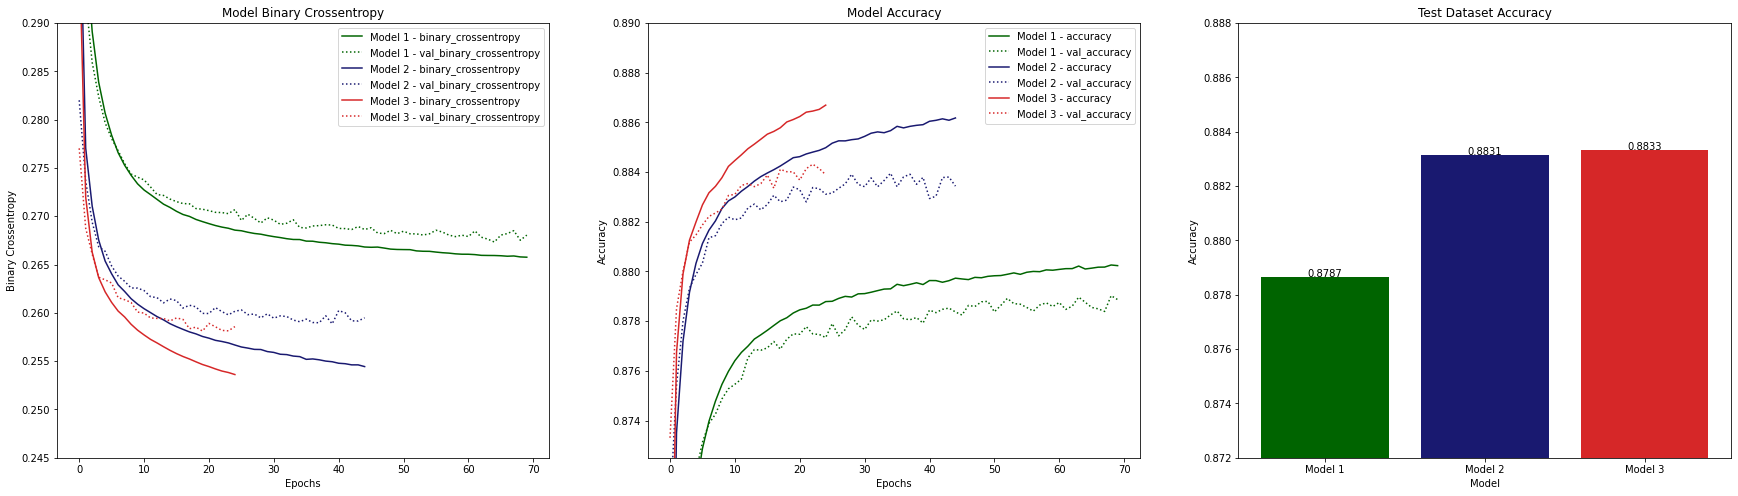

In [24]:
matrices_plot(models_histories, test_matrices, .245, .29, .8725, .89, .872, .888)
# matrices_plot(hh, tt, .245, .29, .87, .89, .87, .888)


The charts above from left to right are:
- **(A) Model Binary Crossentropy on Train Dataset with Number of Epochs**
- **(B) Model Accuracy on Train Dataset with Number of Epochs**
- **(C) Model Accuracy on Test Dataset**

The plot on the left is **(A) Model Binary Crossentropy on Train Dataset with Number of Epochs** and the plot in the middle is **(B) Model Accuracy on Train Dataset with Number of Epochs**. The solid lines show the training loss and accuracy, and the dashed lines show the validation loss and accuracy (remember: a lower validation loss, and a higher validation acuracy indicate a better model).<br>

From the plots, we can see that Model 1 was trained until about 70 epochs before the training process stopped.  While Model 2 and Model 3 were trained for about 45 and 25 epochs, respectively.  This is because of the EarlyStopping that we added to monitor when there is no improvement in the validation Binary Crossentropy for five consecutive epochs.<br>

The (A) Model Binary Crossentropy on Train Dataset with Number of Epochs shows that, Model 1 has the highest loss value, follows by Model 2 and Model 3. The Binary Crossentropy values of the validation set are higher than the train set for all 3 models. Moreover, the higher number of epochs, the higher discrepancy between the train and validatiion set on Binary Crossentropy. With more complex model, the discrepancy are bigger at the smaller epochs.<br>

For the (B) Model Accuracy on Train Dataset with Number of Epochs. It shows that, Model 1 lowest accuracy, follows by Model 2 and Model 3. Same as (A), the higher number of epochs, the higher discrepancy between the train and validatiion set on model accuracy. The model accuracy values of the validation set are lower than the train set. <br>

The bar chart on the right is **(C) Model Accuracy on Test Dataset**.  As you can see that Model 3 (5 dense layers) gives the highest accuracy when evaluated to the test dataset.

These demostrate that all of our 3 models fit the train dataset better than the validation set and the test dataset. These also suggest that the higher level of complexity models, the stronger **overfitting** model to the train dataset are.

<img src="https://miro.medium.com/max/698/1*lARssDbZVTvk4S-Dk1g-eA.png" style="float: right" width="500"/>

### Overfitting and Underfitting Prevention
> #### We decided to proceed to the next step with Model 3 which gives the highest accuracy when applied to the test dataset. However, we need to optimize the model better to prevent overfitting.<br>

To prevent overfitting, we used two techniques below:
- **Regularization**: Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes. We applied the 2 parameters below:
    - **Kernel Regularizer**: Regularizer to apply a penalty on the layer's kernel.
    - **L2 Regularization**: The cost added is proportional to the square of the value of the weights coefficients.
<br>
- **Dropout**: The Dropout applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. 
    - **Dropout Rate** is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. We set all droupout rate to 0.2.

###### *<div style="text-align: right">Image Credits: https://towardsdatascience.com/techniques-for-handling-underfitting-and-overfitting-in-machine-learning-348daa2380b9</div>*

### **Model 3A**

For this model, we decided to make it a **conservative model** by adding Kernal Regularizer, L2, with penalty of 0.01 to all hidden layers and adding a dropout layer (dropout rate = 0.2) after every hidden layer:
- First hidden layer with 256 neurons, Relu Activation Function, and Kernal Regularizer (L2) with penalty of 0.01
- Dropout layer #1 with 0.2 dropout rate added
- Second hidden layer with 128 neurons, Relu Activation Function, and Kernal Regularizer (L2) with penalty of 0.01
- Dropout layer #2 with 0.2 dropout rate added
- Third hidden layer with 64 neurons, Relu Activation Function, and Kernal Regularizer (L2) with penalty of 0.01
- Dropout layer #2 with 0.2 dropout rate added
- Fourth hidden layer with 32 neurons, Relu Activation Function, and Kernal Regularizer (L2) with penalty of 0.01
- Dropout layer #2 with 0.2 dropout rate added
- Output layer with Sigmoid Activation Function

In [25]:
# Model 3A
model3a = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation = 'relu', input_shape=(X_train_.shape[1], ), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model3a, 'Model 3A')
models_histories['Model 3A'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 9ms/step - loss: 0.3258 - binary_crossentropy: 0.2973 - accuracy: 0.8609 - F1: 0.8645


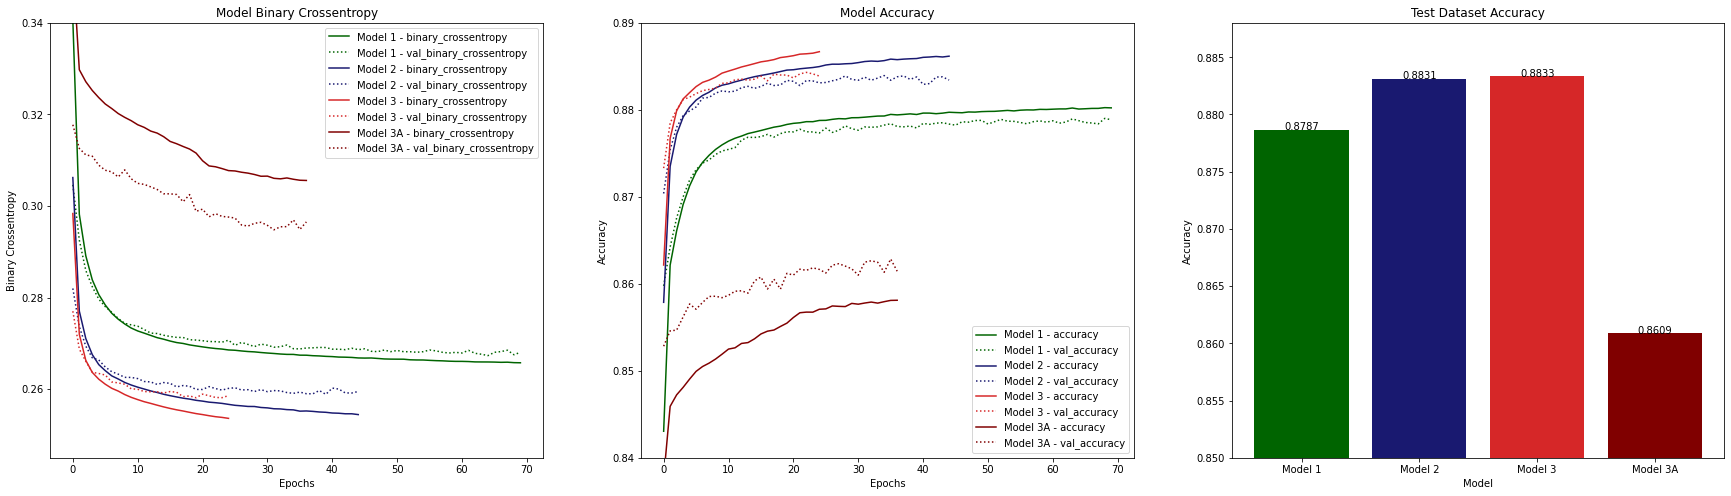

In [26]:
matrices_plot(models_histories, test_matrices, .245, .34, .84, .89, .85, .888)

Model 3A, the **conservative model**, cleayly shows an under fitting to the dataset on both the **(A) Model Binary Crossentropy on Train Dataset with Number of Epochs** plot on the left and the **(B) Model Accuracy on Train Dataset with Number of Epochs** plot in the middle.

The (A) shows that the Binary Crossentropy values of the validation set are lower than the train set.<br>
While, the (B) show that the model accuracy values of the validation set are higher than the train set.

The idea of under fitting also supported by low accuracy value when applied the model to the test dataset as shown in the bar chart on the right, **(C) Model Accuracy on Test Dataset**.
<br><br>
**One good observation** here is that, the overfitting models show that the Binary Crossentropy values of the validation set are higher than the train set and the model accuracy values of the validation set are lower than the train set.<br>
While the under fitting models show that the Binary Crossentropy values of the validation set are lower than the train set and the model accuracy values of the validation set are higher than the train set.
<br><br>
#### <center> What we learnt from Model 3A is that, making the model too conservative by adding too many regularizers and dropout layers can cause the model to be underfitting.</center>

To avoid that, maybe adding **'just right'** regularizers and dropout layers should prevent a model from both overfitting and underfitting. To do so, we created 2 models below; Model 3B and 3C, to observe our hypothesis and results.
<br><br>


### **Model 3B**

For this model, we decided to add a Kernal Regularizer, L2, with penalty of 0.01 to only **the second hidden layer**, the middle layer, and add a dropout layer (dropout rate = 0.2) after it:
- First hidden layer with 256 neurons and Relu Activation Function
- Second hidden layer with 128 neurons, Relu Activation Function, and Kernal Regularizer (L2) with penalty of 0.01
- Dropout layer with 0.2 dropout rate added
- Third hidden layer with 64 neurons and Relu Activation Function
- Fourth hidden layer with 32 neurons and Relu Activation Function
- Output layer with Sigmoid Activation Function

In [27]:
# Model 3B
model3b = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model3b, 'Model 3B')
models_histories['Model 3B'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 8ms/step - loss: 0.2686 - binary_crossentropy: 0.2638 - accuracy: 0.8809 - F1: 0.8843


### **Model 3C**

We would like to see if adding the regularizer and dropout layer too soon or too late into the network will make the model performs differently.<br>
For this model, we decided to add a Kernal Regularizer, L2, with penalty of 0.01 to only **the third hidden layer**, the middle layer, and add a dropout layer (dropout rate = 0.2) after it:
- First hidden layer with 256 neurons and Relu Activation Function
- Second hidden layer with 128 neurons and Relu Activation Function
- Third hidden layer with 64 neurons, Relu Activation Function, and Kernal Regularizer (L2) with penalty of 0.01
- Dropout layer with 0.2 dropout rate added
- Fourth hidden layer with 32 neurons and Relu Activation Function
- Output layer with Sigmoid Activation Function

In [28]:
# Model 3C
model3c = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model3c, 'Model 3C')
models_histories['Model 3C'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 9ms/step - loss: 0.2600 - binary_crossentropy: 0.2578 - accuracy: 0.8843 - F1: 0.8857


---
### Results

The charts below from left to right are:
- **(A) Model Binary Crossentropy on Train Dataset with Number of Epochs** The solid lines show the training loss, and the dashed lines show the validation loss.
- **(B) Model Accuracy on Train Dataset with Number of Epochs** The solid lines show the training accuracy, and the dashed lines show the validation accuracy.
- **(C) Model Accuracy on Test Dataset**

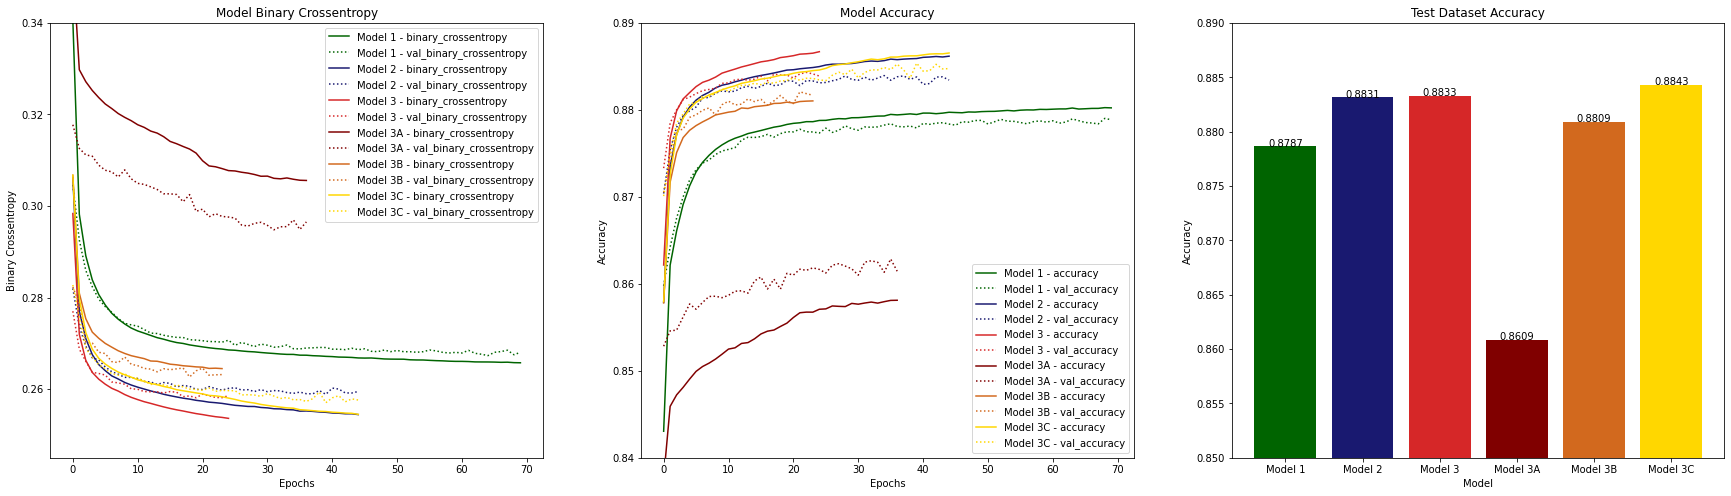

In [29]:
matrices_plot(models_histories, test_matrices, .245, .34, .84, .89, .85, .89)

The table below that is **the model matrices on test dataset** for **model's loss, binary_crossentropy, accuracy,	F1-score, and training time (in seconds)**.

In [30]:
test_matrices

,model,loss,binary_crossentropy,acc,f1,training_time
0,Model 1,0.268542,0.268542,0.878651,0.881497,468.038826
0,Model 2,0.259861,0.259861,0.883143,0.884500,531.603642
0,Model 3,0.259130,0.259130,0.883321,0.886491,366.113192
0,Model 3A,0.325757,0.297283,0.860869,0.864473,1314.139245
0,Model 3B,0.268564,0.263833,0.880916,0.884261,438.961377
0,Model 3C,0.259986,0.257841,0.884311,0.885712,692.644088


The combination chart below display **the model matrices on test dataset** for **model's binary_crossentropy, accuracy,	F1-score, and training time**.

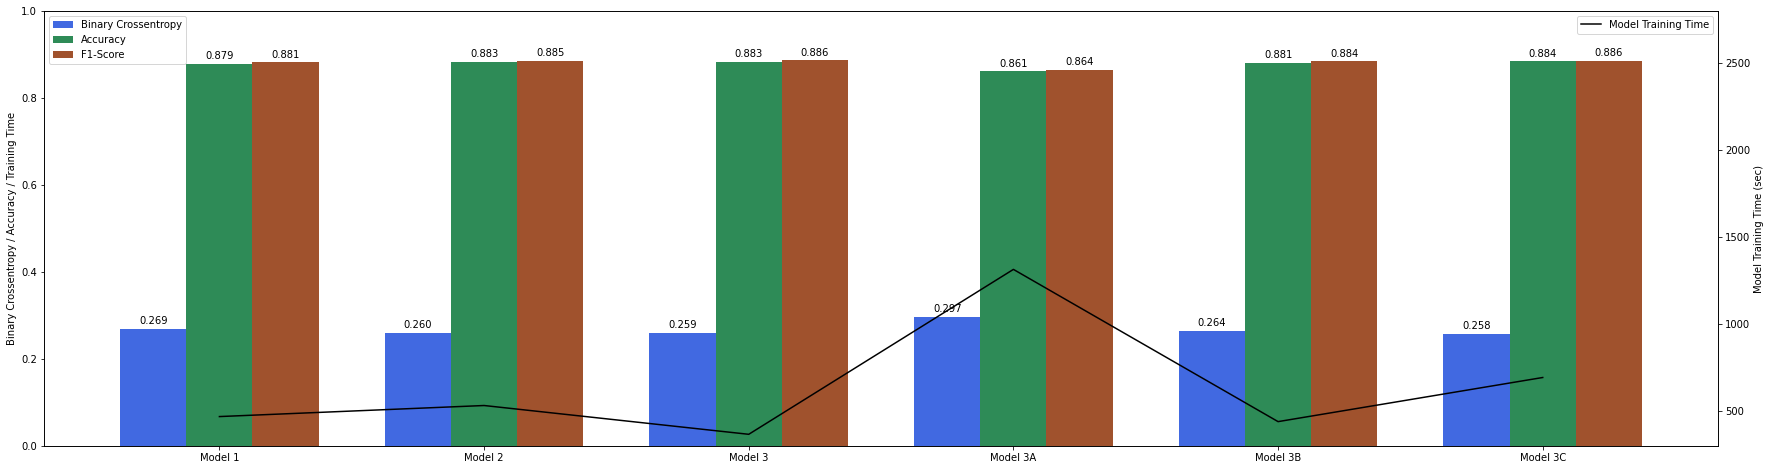

In [31]:
# Create figure and axis #1
fig, ax1 = plt.subplots(figsize=(30,8))
# plot line chart on axis #1
x = np.arange(len(test_matrices['model']))  # the label locations
width = 0.25  # the width of the bars
a1 = ax1.bar(x-width, test_matrices['binary_crossentropy'], width, color='royalblue', label = 'Binary Crossentropy')
a2 = ax1.bar(x, test_matrices['acc'], width, color='seagreen', label='Accuracy')
a3 = ax1.bar(x+width, test_matrices['f1'], width, color='sienna', label = 'F1-Score')
ax1.bar_label(a1, padding=3, fmt='%.3f')
ax1.bar_label(a2, padding=3, fmt='%.3f')
ax1.bar_label(a3, padding=3, fmt='%.3f')
ax1.grid(False) # turn off grid #2
ax1.set_ylabel('Binary Crossentropy / Accuracy / Training Time')
ax1.set_ylim(0, 1)
ax1.legend(loc="upper left")
# plt.grid(axis='y', color = 'gainsboro')
# set up the 2nd axis
ax2 = ax1.twinx()
# plot bar chart on axis #2

ax2.plot(test_matrices['model'], test_matrices['training_time'], color='black') 
ax2.set_ylabel('Model Training Time (sec)')
ax2.set_ylim(300, 2800)
ax2.legend(['Model Training Time'], loc="upper right")

plt.show()

With EarlyStopping added, we created 6 models in total.

- **Model 1**: the simplest model with 2 dense layers able to achieve the binary crossentropy ot 0.269, accuracy of 0.879, and F1-score of 0.881 with the training time of 468 seconds or about 8 minutes.
- **Model 2**: with 3 dense layers achieved the binary crossentropy ot 0.260, accuracy of 0.883, and F1-score of 0.885 with the training time of 532 seconds or 9 minutes.
- **Model 3**: with 5 dense layers achieved the binary crossentropy ot 0.259, accuracy of 0.883, and F1-score of 0.886 with the training time of 366 seconds or about 6 minutes.

We decided to proceed to the next step by tuning the Model 3 which gives the highest accuracy.

However, based on the model Binary Crossentropy and Training Accuracy plots, the model clearly shows overfitting.<br>
To prevent the overfitting, we added regularizer and dropout layer to the network in different locations, created Model 3A, 3B, and 3C.

- **Model 3A**: the conservative model with 5 dense layers, L2 regularizer and dropout layers on all hidden layers achieved the binary crossentropy ot 0.298, accuracy of 0.861, and F1-score of 0.864 with the training time of 1,314 seconds or about 22 minutes.

According to the model Binary Crossentropy and Training Accuracy plots, we observed model under fitting.
We decided to try adding a regularizer and dropout layer to only one hidden layer which should be enough to prevent a model from both overfitting and underfitting.

- **Model 3B**: the conservative model with 5 dense layers, L2 regularizer and dropout layers on the second hidden layer achieved the binary crossentropy ot 0.265, accuracy of 0.881, and F1-score of 0.882 with the training time of 439 seconds or about 7 minutes.
- **Model 3C**: the conservative model with 5 dense layers, L2 regularizer and dropout layers on the third hidden layer achieved the binary crossentropy ot 0.259, accuracy of 0.884, and F1-score of 0.885 with the training time of 693 seconds or about 12 minutes.

Observing on the Model 3B and 3C Binary Crossentropy and Training Accuracy plots, the models show good performance optimizing both overfitting and underfitting.  The models also show good results when applying to the test dataset!
<br><br><br>

### Conclusions

- The goal for this case study is to build a classification model using a dense neural network to distinguish between the existance of a new particle and to maximize the accuracy. The model's interpability is not required.
- The dataset is complete, no missing data and no duplication.
- There are no evidence of correlation was found among any of the feature.
- To evaluate the models performance, we were looking at 4 matrices; Binary crossentropy, Accuracy, F1 Score, and Training Time.
- From the result, it is clear that:
    - More complex model, most likely means higher computational cost.
    - Adding **EarlyStopping** helps preventing unneccesary training time based on certain parameters.
    - **Overfitting** can be prevented by using techniques like **Regularization, Dropout**, etc.
    - However, too many regularizers or dropout layers can cause **underfitting** to the model.
    - Adding regularizer(s) and dropout layer(s) too soon or too late into the network affects the model performance.<br>
    
#### <center> Based on the model behaviors and performance, our recommendation for **the most useful model amongst all 6 models in this case study is Model 3C**. <br>The model provides (on test dataset) the highest accuracy at 0.8843, the highest F1-score at 0.886, the lowest binary crossentropy loss at 0.258, with moderate training time at 12 minutes. </center>
<br>

### Discussions
- Having a domain expert to help clarify features in this case study will be very helpful.
- Other algorithms that can be useful for classification such as, Logistic Regression, Random Forest, XGBoost, etc. can be used for further research. However, with this size of data, the computational cost will be high.
<br><br>

---
### Moving Forward

We observed that the higher level of complexity models, the stronger **overfitting** model to the train dataset are.

To prevent the overfitting, adding regularizer and dropout layer are ones of the best techniques used.
However, adding too many regularizers and dropout layers can cause the model to be underfitting.<br>

Adding the regularizer and dropout layer too soon or too late into the network makes it different for the model performance.

The key is to add **'just right'** amount and location for regularizers and dropout layers will prevent a model from both overfitting and underfitting.  This also will allow the model to perform well with the new data!
<br><br><br>

### Future Research

In this study:
- Like what we mentioned in the Model Building section, we built all models with the same set up of parameters: Optimizer, EarlyStopping, Epochs, Batchsize, Number of Neurons Hidden Layers.
- We built models with only 2, 3, and 5 layers.
- We added regularizer and dropout layer, either to all hidden layers, or to only single hidden layer.

All parameters above can be adjusted and/or droped. New paramerters can also be added. Or more data used for training.<br>
**With all those adjustments, the new model can be performing better than what we currently have from this study.**

Two things to note here are that:
- To train the more complex model might also mean a higher computational cost. Adding EarlyStopping can help preventing unneccesary training time based on certain parameters.<br>
- Overfitting and underfitting can be prevented by various kind of techniques.

---